In [43]:
# imports
import pandas as pd
import torch
import numpy as np
import sys
import os
from scipy import stats
from evoaug_utils.model_zoo import DeepSTARR

# Add path to Train_Oracle_Model directory for imports
sys.path.append('../Train_Oracle_Model')
from distill_EvoAug2 import UncertaintyAwareStudent, UncertaintyAwareLightningModel

from tangermeme.utils import one_hot_encode
from tangermeme.predict import predict
from tangermeme.deep_lift_shap import deep_lift_shap
from tqdm import trange
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt


In [44]:
# Check gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [45]:
def predict(model, X, args=None, func=None, batch_size=32, dtype=None, 
    device='cuda', verbose=False):
    """Make batched predictions in a memory-efficient manner.

    This function will take a PyTorch model and make predictions from it using
    the forward function, with optional additional arguments to the model. The
    additional arguments must have the same batch size as the examples, and the
    i-th example will be given to the model with the i-th index of each
    additional argument. 

    Before starting predictions, the model is moved to the specified device. As 
    predictions are being made, each batch is also moved to the specified 
    device and then moved back to the CPU after predictions are made. Each batch
    is converted to the provided dtype if provided, keeping the original blob of
    examples in the original dtype. These features allow the function to work on 
    massive data sets that do not fit in GPU memory. For example, the original
    sequences can be kept as 8-bit integers for compression and each batch will
    be upcast to the desired precision. If a single batch does not fit in memory,
    try lowering the batch size.


    Parameters
    ----------
    model: torch.nn.Module
        The PyTorch model to use to make predictions.

    X: torch.tensor, shape=(-1, len(alphabet), length)
        A one-hot encoded set of sequences to make predictions for.

    args: tuple or list or None, optional
        An optional set of additional arguments to pass into the model. If
        provided, each element in the tuple or list is one input to the model
        and the element must be formatted to be the same batch size as `X`. If
        None, no additional arguments are passed into the forward function.
        Default is None.

    func: function or None, optional 
        A function to apply to a batch of predictions after they have been made.
        If None, do nothing to them. Default is None.

    batch_size: int, optional
        The number of examples to make predictions for at a time. Default is 32.

    dtype: str or torch.dtype or None, optional
        The dtype to use with mixed precision autocasting. If None, use the dtype of
        the *model*. This allows you to use int8 to represent large data sets and
        only convert batches to the higher precision, saving memory. Defailt is None.

    device: str or torch.device, optional
        The device to move the model and batches to when making predictions. If
        set to 'cuda' without a GPU, this function will crash and must be set
        to 'cpu'. Default is 'cuda'. 

    verbose: bool, optional
        Whether to display a progress bar during predictions. Default is False.


    Returns
    -------
    y: torch.Tensor or list/tuple of torch.Tensors
        The output from the model for each input example. The precise format
        is determined by the model. If the model outputs a single tensor,
        y is a single tensor concatenated across all batches. If the model
        outputs multiple tensors, y is a list of tensors which are each
        concatenated across all batches.
    """

    model = model.to(device).eval()
    
    if dtype is None:
        try:
            dtype = next(model.parameters()).dtype
        except:
            dtype = torch.float32
    elif isinstance(dtype, str):
        dtype = getattr(torch, dtype)

    if args is not None:
        for arg in args:
            if arg.shape[0] != X.shape[0]:
                raise ValueError("Arguments must have the same first " +
                    "dimension as X")

    ###

    y = []
    with torch.no_grad():
        batch_size = min(batch_size, X.shape[0])

        for start in trange(0, X.shape[0], batch_size, disable=not verbose):
            end = start + batch_size
            X_ = X[start:end].type(dtype).to(device)

            if X_.shape[0] == 0:
                continue

            with torch.autocast(device_type=device, dtype=dtype):
                if args is not None:
                    args_ = [a[start:end].type(dtype).to(device) for a in args]
                    y_ = model(X_, *args_)
                else:
                    y_ = model(X_)

            # If a post-processing function is provided, apply it to the raw output
            # from the model.
            if func is not None:
                y_ = func(y_)

            # Move to the CPU
            if isinstance(y_, torch.Tensor):
                y_ = y_.cpu()
            elif isinstance(y_, (list, tuple)):
                y_ = tuple(yi.cpu() for yi in y_)
            elif isinstance(y_, dict):
                # Handle dictionary output (like your UncertaintyAwareStudent)
                y_ = {k: v.cpu() if isinstance(v, torch.Tensor) else v for k, v in y_.items()}
            else:
                raise ValueError("Cannot interpret output from model.")

            y.append(y_)

    # Concatenate the outputs
    if isinstance(y[0], torch.Tensor):
        y = torch.cat(y)
    elif isinstance(y[0], dict):
        # Handle dictionary concatenation
        y = {k: torch.cat([batch[k] for batch in y]) for k in y[0].keys()}
    else:
        y = [torch.cat(y_) for y_ in list(zip(*y))]

    return y


In [46]:
# import libraries

dev_sequences_df = pd.read_csv('Libraries/Dev_CEseek_sequences.csv')
hk_sequences_df = pd.read_csv('Libraries/Hk_CEseek_sequences.csv')

dev_sequences_df.head(10)

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,ce_start,ce_end,log2_fc,p_value,dataset
0,"('Dref', 'GATAe', '+', '+', 5)",+,TATCGATAGATTGCGATAAC,TTACTTTATACTTGAGATAGTAGTCTATCGATAGATTGCGATAACC...,1584661,25,44,5.321928,3.162613e-04,dev
1,"('twi', 'twi', '+', '-', 6)",+,ACACATATATGTACATATGT,CAAGTGCCGCAGAAACATTTGCTGATAAAATGCAAGATTTCATAAT...,846257,155,174,36.219281,4.635498e-09,dev
2,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,ATTTAGCACGAGAAAACACAGATAATTGGCTATTCACAGCGACATA...,620728,220,229,4.574315,5.067241e-114,dev
3,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,AAAAATAGTTTTAAATAATTTTATTGAAATAGAAGTTTCAAAAAAT...,433870,112,121,4.574315,5.067241e-114,dev
4,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAC,AAAACGAAAACGTAGAGCTACCGTGCTTGGGTTCGATACTTGTGCT...,639485,53,62,4.574315,5.067241e-114,dev
5,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,AAAACATTTGATCAAAAACACAAATAAGAAAAATTTCCCACCATTT...,710270,122,131,4.574315,5.067241e-114,dev
6,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAC,AAAACGCAATATTCGTTTTTACATTCGCATTTGTTGCGAATAAATA...,139095,153,162,4.574315,5.067241e-114,dev
7,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,GCGTAACTTTGAAAGACTTTCAGAAAAATATCAATTTTTGGTTTCC...,18536,110,119,4.574315,5.067241e-114,dev
8,"('GATAe', 'Jra', '+', '+', 4)",+,AGATAAGCTAAGTGAATCATG,TGCCGTCAGATAAGCTAAGTGAATCATGCAATGAAGAGAGGCAATG...,276895,7,27,6.643856,3.851699e-10,dev
9,"('Dref', 'Dref', '+', '-', 5)",+,TATCGATAGATTCAGTCGATA,GAGTTGCAGAGCTGCGAGGAATGATTAAAGCTGCAGGCCGCTTAGA...,847311,213,233,5.906891,2.398414e-11,dev


In [47]:
# Load EvoAug DeepSTARR student model
# Use pylightning student architecture from distill_EvoAug2.py

# Add path to Train_Oracle_Model directory for imports
sys.path.append('../Train_Oracle_Model')


# Paths
output_dir = '../Train_Oracle_Model/EvoAug_ensemble_10'
# New folder for saving outputs
selection_dir = './Libraries'
os.makedirs(selection_dir, exist_ok=True)
student_ckpt = os.path.join(output_dir, 'EvoAug_student_model.ckpt')

# Build a minimal "teacher" with just the DeepSTARR architecture (no weights)
teacher_model = type("Teacher", (), {"model": DeepSTARR(2)})()

# Build student and load trained weights
student_model = UncertaintyAwareStudent(teacher_model, num_tasks=2)
lightning_student = UncertaintyAwareLightningModel.load_from_checkpoint(student_ckpt, student_model=student_model)

# Device + eval
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lightning_student.to(device).eval()

print("Student model loaded successfully")

Student model loaded successfully


In [48]:
# Score library with EvoAug student model using efficient batched prediction

def score_library_efficient(library_df, model, batch_size=64):
    library_name = f"{library_df['dataset'].iloc[0].upper()} library"
    dataset_type = library_df['dataset'].iloc[0].lower()  # 'dev' or 'hk'
    
    # One-hot encode all sequences at once
    sequences = [one_hot_encode(seq) for seq in library_df['endogenous_sequence']]
    X = torch.stack(sequences)  # Shape: (n_sequences, 4, seq_length)
    
    # Use the predict function for efficient batched prediction
    predictions = predict(model, X, batch_size=batch_size, device=str(device), verbose=True)
    
    # Handle dictionary output (your model returns {'mean': tensor, 'uncertainty': tensor})
    if isinstance(predictions, dict):
        y_pred = predictions['mean'].numpy()
    else:
        y_pred = predictions.numpy()
    
    # Extract the correct task predictions:
    # Model outputs shape: (n_sequences, 2) where [:, 0] = dev, [:, 1] = hk
    if dataset_type == 'dev':
        task_predictions = y_pred[:, 0]  # Use dev predictions (index 0)
        print(f"Using DEV task predictions (index 0) for {library_name}")
    elif dataset_type == 'hk':
        task_predictions = y_pred[:, 1]  # Use hk predictions (index 1)
        print(f"Using HK task predictions (index 1) for {library_name}")
    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")
    
    # Add predictions to dataframe
    library_df = library_df.copy()
    library_df['EvoAug_predictions'] = task_predictions
    print(f'{library_name} scored with EvoAug student model.')
    return library_df

# Score both libraries efficiently with correct task predictions
dev_sequences_df = score_library_efficient(dev_sequences_df, lightning_student)
hk_sequences_df = score_library_efficient(hk_sequences_df, lightning_student)

100%|██████████| 5/5 [00:00<00:00, 29.56it/s]


Using DEV task predictions (index 0) for DEV library
DEV library scored with EvoAug student model.


100%|██████████| 6/6 [00:00<00:00, 30.46it/s]


Using HK task predictions (index 1) for HK library
HK library scored with EvoAug student model.


In [49]:
# Quick summary of library scores
print("Dev Library Summary:")
print(f"     Mean: {np.mean(dev_sequences_df['EvoAug_predictions'])}")
print(f"     Mean: {np.max(dev_sequences_df['EvoAug_predictions'])}")

print("HK Library Summary:")
print(f"     Mean: {np.mean(hk_sequences_df['EvoAug_predictions'])}")
print(f"     Max: {np.max(hk_sequences_df['EvoAug_predictions'])}")



Dev Library Summary:
     Mean: 2.398314952850342
     Mean: 5.307164192199707
HK Library Summary:
     Mean: 4.104406356811523
     Max: 7.51948881149292


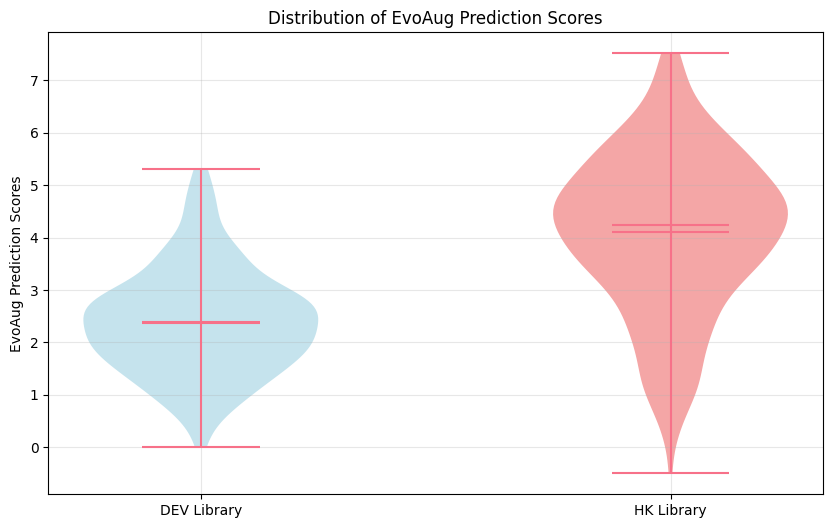

In [50]:
# Plot prediction scores for both libraries
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Prepare data for violin plots
data_to_plot = [dev_sequences_df['EvoAug_predictions'], hk_sequences_df['EvoAug_predictions']]
labels = ['DEV Library', 'HK Library']
positions = [1, 2]

# Create violin plots
violin_parts = plt.violinplot(data_to_plot, positions=positions, showmeans=True, showmedians=True)

# Color the violins
colors = ['lightblue', 'lightcoral']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

# Set x-axis labels
plt.xticks(positions, labels)
plt.ylabel('EvoAug Prediction Scores')
plt.title('Distribution of EvoAug Prediction Scores')
plt.grid(True, alpha=0.3)

# Save as SVG
plt.savefig('Libraries/prediction_scores_violin.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()


In [51]:
dev_sequences_df.sort_values(by='EvoAug_predictions', ascending=False)

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,ce_start,ce_end,log2_fc,p_value,dataset,EvoAug_predictions
281,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAT,TATATCTGTAGCTCAACACCTGACTGCTATCGAATGTTTTGGTATT...,5585,107,116,4.574315,5.067241e-114,dev,5.307164
59,"('Jra', 'Jra', '-', '+', 10)",+,AGTGACTAATCTACTTACAAGTGAATCACG,AATCAGTTGAAATTTATACCTCATCGTCGACAATGCGAGTCGTCGC...,2590,100,129,5.321928,1.763198e-07,dev,5.268048
167,"('Dref', 'Dref', '-', '+', 4)",+,TATCGATATCACTATCGATA,TTATTAGCCGGCAAAATTGGTGGGTAAACAACAAATATTTGGACAA...,19539,117,136,38.219281,4.230561e-34,dev,5.127221
226,"('Jra', 'twi', '+', '-', 4)",+,GTGAATCACATCGACATATGT,GACTTTTCATTCCATTGTTCTTGGTTCTCGGAAGTATCAACTTATT...,626,128,148,34.219281,8.262587e-03,dev,5.112831
61,"('Dref', 'Max', '-', '+', 6)",+,TATCGATATTTGATAGCACGTG,TAATTAAGAGCAACAACAACAAACTTAGTAATGACACCCAAATAGA...,10613,155,176,35.219281,6.820836e-05,dev,5.037681
...,...,...,...,...,...,...,...,...,...,...,...
107,"('GATAe', 'GATAe', '-', '-', 10)",+,CTTATCGAATTGTTCGCATTATCG,AGCGACGCCCAACCAAGCTTATCGAATTGTTCGCATTATCGTTTAG...,1829171,17,40,5.643856,2.120598e-09,dev,0.470674
54,"('Dref', 'GATAe', '+', '+', -5)",-,TATCGATAAT,AATATCGATAATTTCATCGACTGAGCTTTTGTGGGCCAATTTGATT...,1287567,2,11,4.574315,5.067241e-114,dev,0.421761
237,"('Dref', 'Dref', '+', '+', 2)",+,TATCGAAATCTATCGATT,GCAGTAAAACTTCAACCAATCTATCGAAATCTATCGATTGTTAAGT...,1872003,21,38,35.219281,6.820836e-05,dev,0.175573
81,"('GATAe', 'GATAe', '-', '-', 10)",+,CGATAATGCGAACAATTCGATAAG,GATGCCATACGCTCCGGGCGGCTGGTAAGCTTAGTAATTACATGTC...,1973682,108,131,5.643856,2.120598e-09,dev,0.136530


In [52]:
hk_sequences_df.sort_values(by='EvoAug_predictions', ascending=False)

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,ce_start,ce_end,log2_fc,p_value,dataset,EvoAug_predictions
67,"('Dref', 'Max', '-', '+', 6)",+,TATCGATATTTGATAGCACGTG,TAATTAAGAGCAACAACAACAAACTTAGTAATGACACCCAAATAGA...,4637,155,176,35.219281,6.817735e-05,hk,7.519489
306,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAT,TATATCTGTAGCTCAACACCTGACTGCTATCGAATGTTTTGGTATT...,605,107,116,6.174824,3.293969e-316,hk,7.509891
193,"('Dref', 'Dref', '-', '+', 4)",+,TATCGATATCACTATCGATA,TTATTAGCCGGCAAAATTGGTGGGTAAACAACAAATATTTGGACAA...,17547,117,136,38.678713,1.131588e-46,hk,7.449952
125,"('Dref', 'Dref', '-', '+', 1)",+,ATTCGATACTATCGATA,TGAGAGTAATTTACCTTTTAAAACACTTGAAAAGGTTTTAAACACG...,133078,112,128,38.804243,7.311219e-51,hk,7.194820
72,"('Dref', 'Jra', '+', '+', -3)",+,TATCGATTACTCAGC,CGAGTTTAATTTAATTTCAGTTTCTGTTTCGACACGAGCAGTCAGC...,207805,139,153,5.321928,3.161250e-04,hk,7.171278
...,...,...,...,...,...,...,...,...,...,...,...
173,"('CTCF', 'Max', '-', '-', -2)",+,GAGCCACCCACATGGA,TATTTAAGGCGGATGCATCGGAAATAAACTAAAGCGAACAAAATAC...,1372703,215,230,34.219281,8.261961e-03,hk,0.512133
163,"('GATAe', 'GATAe', '+', '+', 0)",+,CGATAACTGATAAG,TTTGTTGTTGTTGTTTTTGTTGCTGGTCTTCTACTATCTGTGTATC...,1460863,229,242,4.321928,8.797089e-04,hk,0.506324
206,"('Jra', 'twi', '-', '-', -3)",+,GGTGAGTCATCTGT,GCGGCGGGAGCGGGACAGCGAGCGGCTAGCTTTTTTTTTTTATTAT...,1357262,212,225,3.514573,1.656108e-05,hk,0.429658
40,"('twi', 'twi', '+', '-', 9)",+,ACAGATGTGACATTAATATGTGT,TGCTCGCTGCTCTTGTTCTTCCTCGACGGTCCCCAAATGCCATTCG...,1375164,186,208,34.219281,8.261961e-03,hk,0.285277


In [53]:
dev_sequences_df

,ce_name,orientation,ce_sequence,endogenous_sequence,pseudo_index,ce_start,ce_end,log2_fc,p_value,dataset,EvoAug_predictions
0,"('Dref', 'GATAe', '+', '+', 5)",+,TATCGATAGATTGCGATAAC,TTACTTTATACTTGAGATAGTAGTCTATCGATAGATTGCGATAACC...,1584661,25,44,5.321928,3.162613e-04,dev,1.731805
1,"('twi', 'twi', '+', '-', 6)",+,ACACATATATGTACATATGT,CAAGTGCCGCAGAAACATTTGCTGATAAAATGCAAGATTTCATAAT...,846257,155,174,36.219281,4.635498e-09,dev,3.400607
2,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,ATTTAGCACGAGAAAACACAGATAATTGGCTATTCACAGCGACATA...,620728,220,229,4.574315,5.067241e-114,dev,2.670926
3,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAG,AAAAATAGTTTTAAATAATTTTATTGAAATAGAAGTTTCAAAAAAT...,433870,112,121,4.574315,5.067241e-114,dev,3.647285
4,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAC,AAAACGAAAACGTAGAGCTACCGTGCTTGGGTTCGATACTTGTGCT...,639485,53,62,4.574315,5.067241e-114,dev,2.334070
...,...,...,...,...,...,...,...,...,...,...,...
297,"('Dref', 'GATAe', '+', '+', -5)",+,TATCGATAAC,TGCTAAAACACACGGATAAATGTAAAAGTTTATGTTAATTGTTCGT...,33986,122,131,4.574315,5.067241e-114,dev,3.473825
298,"('Dref', 'GATAe', '+', '-', -1)",+,TATCGATGTTATCG,TTAAAATTGTCTTTTACGGGGGAAAATGGGAAAATGATTTCTATTA...,186452,200,213,4.906891,2.798588e-03,dev,2.066938
299,"('twi', 'twi', '+', '+', 1)",+,ACATATGTACATATG,TTCGCACACACACTCTAACTCACACATAAACACACACACACATAGA...,63923,179,193,6.129283,1.588411e-25,dev,2.694608
300,"('Dref', 'GATAe', '-', '+', 1)",+,GATCGATACCGATAAG,TTTTCTTCGGGTTCAAGTGACAGCGTCGCAGGGCCATTTTGTTTCA...,1289480,158,173,4.906891,1.339743e-05,dev,1.668938


In [54]:
# Setup IntegratedGradients for attribution calculation
import torch.nn as nn
from captum.attr import IntegratedGradients

# Create a simple wrapper that works with Captum
class CaptumWrapper(nn.Module):
    """Wrapper for Captum attribution methods."""
    
    def __init__(self, lightning_student):
        super().__init__()
        self.lightning_student = lightning_student
    
    def forward(self, x):
        """Forward pass that returns only mean predictions."""
        outputs = self.lightning_student(x)
        if isinstance(outputs, dict):
            return outputs['mean']
        else:
            return outputs

# Create the wrapper and IntegratedGradients attributer
captum_model = CaptumWrapper(lightning_student)
captum_model.to(device).eval()
ig = IntegratedGradients(captum_model)

print("IntegratedGradients setup complete!")


IntegratedGradients setup complete!


In [55]:
# Fixed dishuffled baseline function that generates multiple shuffles per sequence
import random
def create_dishuffled_baseline_fixed(sequences, n_shuffles=1):
    """Create dinucleotide-shuffled baseline for IntegratedGradients.
    
    Args:
        sequences: List of sequence strings
        n_shuffles: Number of shuffled versions to generate per sequence (default: 10)
    
    Returns:
        Tensor of shuffled sequences, one per original sequence
    """
    random.seed(42)
    from tangermeme.ersatz import dinucleotide_shuffle
    from tangermeme.utils import characters
    
    # Convert sequences to one-hot
    sequences_ohe = torch.stack([one_hot_encode(seq) for seq in sequences])
    
    # Process each sequence individually to generate multiple shuffles per sequence
    shuffled_sequences = []
    
    for i in range(sequences_ohe.shape[0]):
        # Get single sequence: shape (4, seq_len)
        single_seq = sequences_ohe[i:i+1]  # Keep batch dimension: (1, 4, seq_len)
        
        # Generate n_shuffles shuffled versions: returns shape (1, 4*n_shuffles, seq_len)
        shuffled_batch = dinucleotide_shuffle(single_seq, n=n_shuffles, random_state=None)
        
        # Remove batch dimension: shape (4*n_shuffles, seq_len)
        shuffled_no_batch = shuffled_batch.squeeze(0)  # (4*n_shuffles, seq_len)
        
        # Reshape to (n_shuffles, 4, seq_len)
        shuffled_reshaped = shuffled_no_batch.view(n_shuffles, 4, -1)
        
        # Select the first shuffled version for this sequence
        selected_shuffle = shuffled_reshaped[0]  # (4, seq_len)
        shuffled_sequences.append(selected_shuffle)
    
    return torch.stack(shuffled_sequences)


Calculating IntegratedGradients attributions with multiple shuffles per sequence...

Calculating IntegratedGradients attributions for DEV library...


DEV attributions shape: torch.Size([302, 4, 249])

Calculating IntegratedGradients attributions for HK library...
HK attributions shape: torch.Size([336, 4, 249])

Final shapes:
DEV attributions: (302, 4, 249)
HK attributions: (336, 4, 249)

Attributions saved successfully!


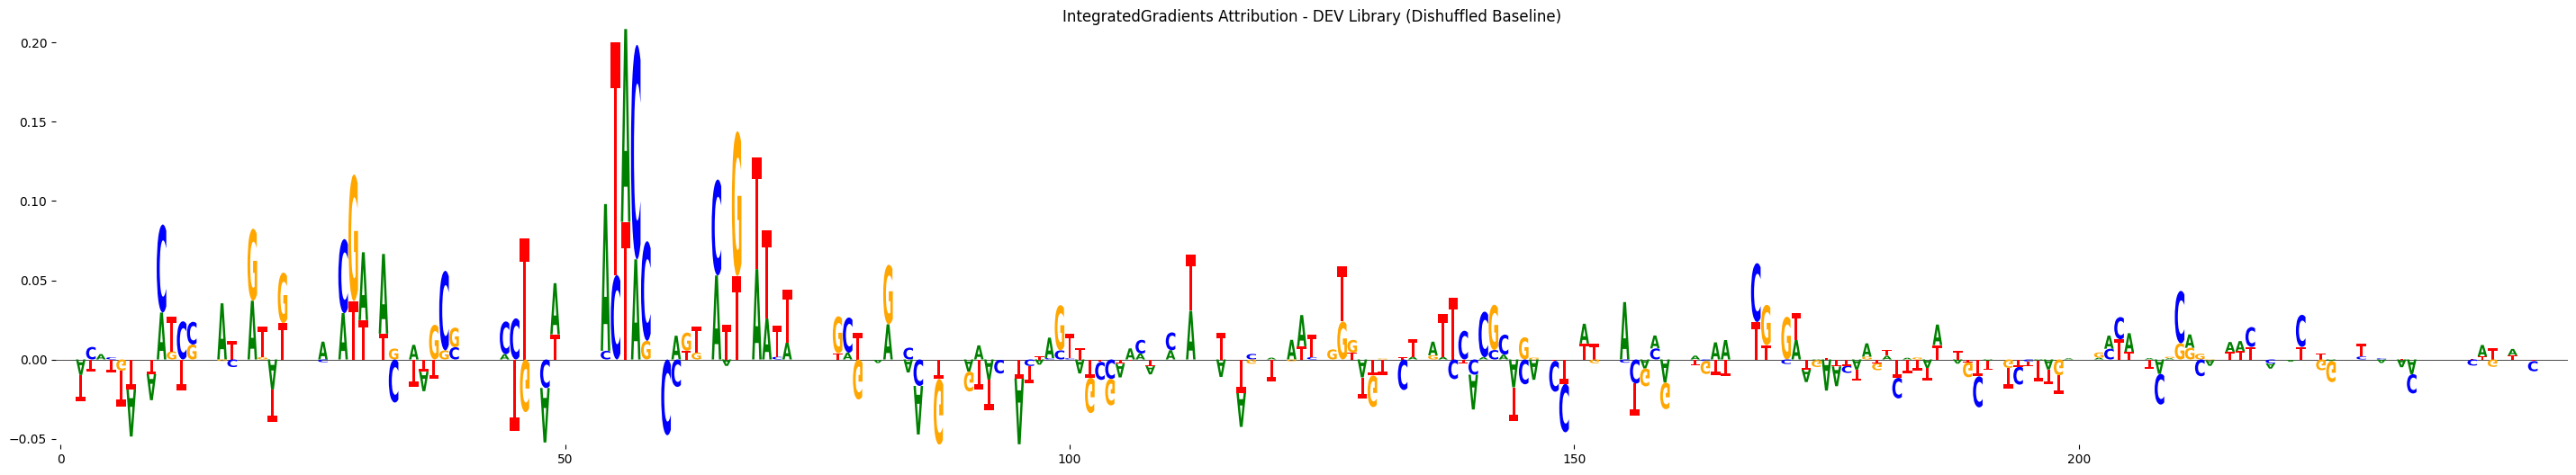

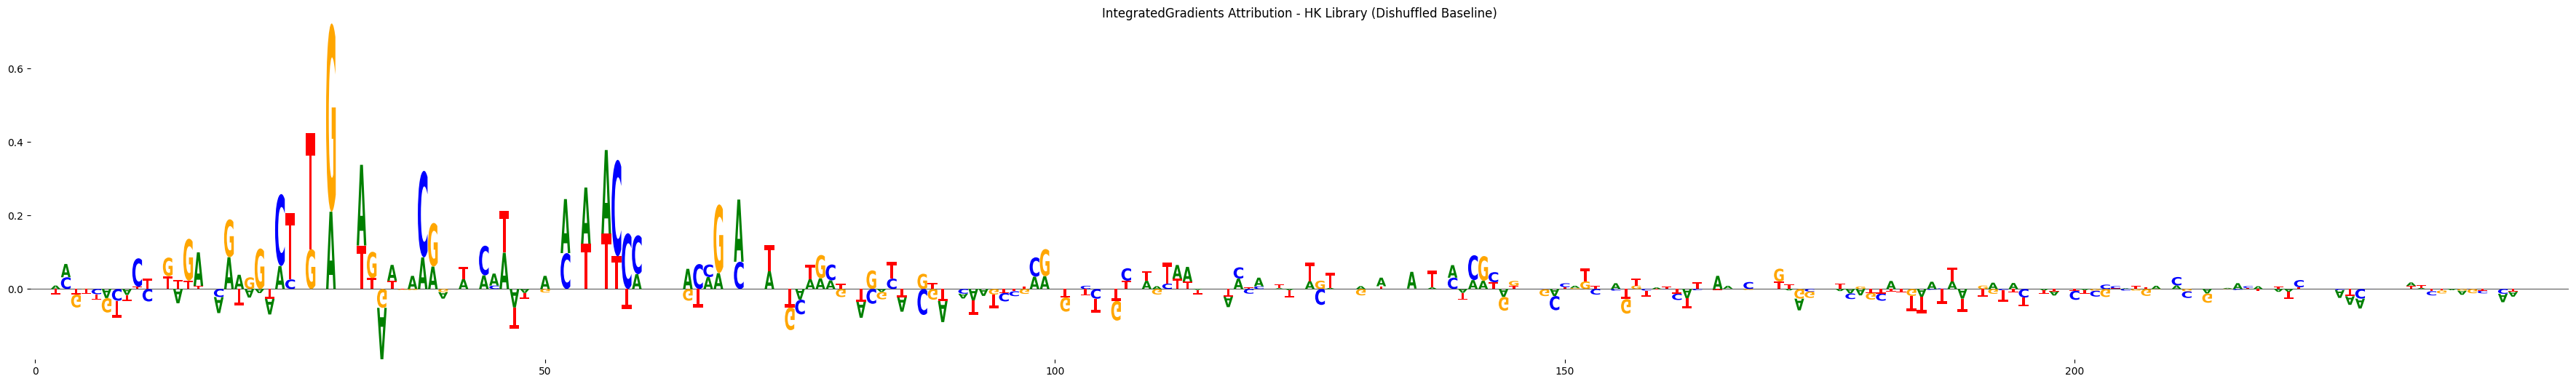

In [ ]:
# Update the attribution calculation to use the fixed dishuffled baseline function
print("Calculating IntegratedGradients attributions with multiple shuffles per sequence...")

# Calculate attributions for DEV library using the fixed function
print("\nCalculating IntegratedGradients attributions for DEV library...")
dev_sequences = torch.stack([one_hot_encode(seq) for seq in dev_sequences_df['endogenous_sequence']]).float()
dev_baselines = create_dishuffled_baseline_fixed(dev_sequences_df['endogenous_sequence'].tolist(), n_shuffles=1)

# Calculate attributions for DEV task (target=0)
dev_attributions = ig.attribute(
    dev_sequences.to(device),
    baselines=dev_baselines.to(device),
    target=0,  # DEV task
    n_steps=50  # Number of integration steps
)

print(f"DEV attributions shape: {dev_attributions.shape}")

# Calculate attributions for HK library using the fixed function
print("\nCalculating IntegratedGradients attributions for HK library...")
hk_sequences = torch.stack([one_hot_encode(seq) for seq in hk_sequences_df['endogenous_sequence']]).float()
hk_baselines = create_dishuffled_baseline_fixed(hk_sequences_df['endogenous_sequence'].tolist(), n_shuffles=1)

# Calculate attributions for HK task (target=1)
hk_attributions = ig.attribute(
    hk_sequences.to(device),
    baselines=hk_baselines.to(device),
    target=1,  # HK task
    n_steps=50  # Number of integration steps
)

print(f"HK attributions shape: {hk_attributions.shape}")

# Convert to numpy for further processing
dev_attr_np = dev_attributions.detach().cpu().numpy()
hk_attr_np = hk_attributions.detach().cpu().numpy()
dev_ohe_np = dev_sequences.numpy()
hk_ohe_np = hk_sequences.numpy()

print(f"\nFinal shapes:")
print(f"DEV attributions: {dev_attr_np.shape}")
print(f"HK attributions: {hk_attr_np.shape}")

# Save the attributions
os.makedirs('Libraries/dev_modisco', exist_ok=True)
os.makedirs('Libraries/hk_modisco', exist_ok=True)

np.savez_compressed('Libraries/dev_modisco/attr.npz', arr_0=dev_attr_np)
np.savez_compressed('Libraries/dev_modisco/ohe.npz', arr_0=dev_ohe_np)
np.savez_compressed('Libraries/hk_modisco/attr.npz', arr_0=hk_attr_np)
np.savez_compressed('Libraries/hk_modisco/ohe.npz', arr_0=hk_ohe_np)

print(f"\nAttributions saved successfully!")

# Plot the attributions
from tangermeme.plot import plot_logo

plt.figure(figsize=(36, 6))
plot_logo(dev_attr_np[0])
plt.title('IntegratedGradients Attribution - DEV Library (Dishuffled Baseline)')

plt.figure(figsize=(45, 6))
plot_logo(hk_attr_np[0])
plt.title('IntegratedGradients Attribution - HK Library (Dishuffled Baseline)')

plt.show()


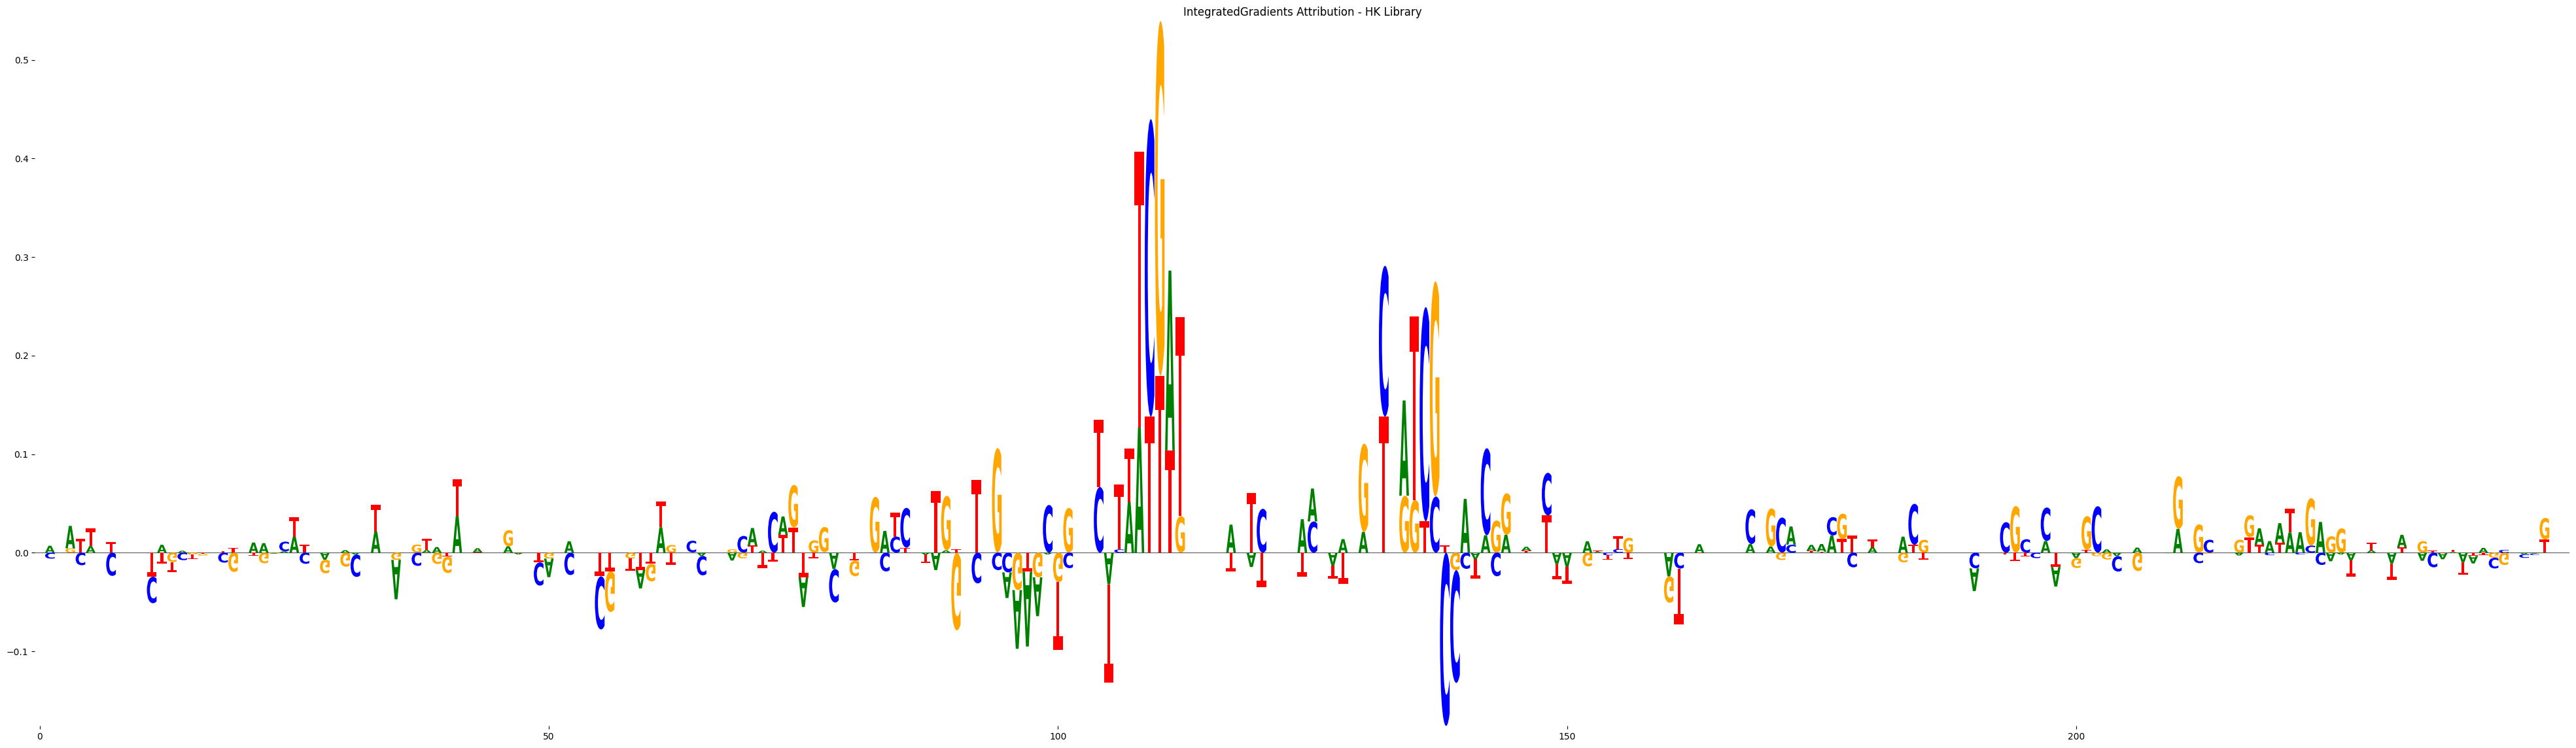

In [57]:


plt.figure(figsize=(50, 14))
plot_logo(hk_attr_np[13])
plt.title('IntegratedGradients Attribution - HK Library')

plt.show()

In [59]:
# Save attributions and one-hot encodings with proper indexing
import os

# Ensure directories exist
os.makedirs('Libraries/dev_modisco', exist_ok=True)
os.makedirs('Libraries/hk_modisco', exist_ok=True)

# Save the original library dataframes with preserved index
dev_sequences_df.to_csv('Libraries/dev_modisco/dev_library.csv', index=True)
hk_sequences_df.to_csv('Libraries/hk_modisco/hk_library.csv', index=True)

print(f"Files saved:")
print(f"DEV: {len(dev_sequences_df)} sequences")
print(f"HK: {len(hk_sequences_df)} sequences")
print(f'Dev attributions had mean: {np.mean(dev_attr_np)} and max: {np.max(dev_attr_np)}')
print(f'Hk attributions had mean: {np.mean(hk_attr_np)} and max: {np.max(hk_attr_np)}')
print(f"Attributions and one-hot encodings saved in .npz format with 'arr_0' key for modisco compatibility")

Files saved:
DEV: 302 sequences
HK: 336 sequences
Dev attributions had mean: 0.0024112408052206695 and max: 0.6466258495289756
Hk attributions had mean: 0.0044648193718901386 and max: 0.7264375999405875
Attributions and one-hot encodings saved in .npz format with 'arr_0' key for modisco compatibility
